In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('amazon_clean4.csv')

In [3]:
df =df.dropna()

In [4]:
df.head()

,product_title,star_rating,review_body
0,Madden NFL 16 - Xbox One Digital Code,2,I keep buying madden every year hoping they ge...
1,Command & Conquer The Ultimate Collection [Ins...,5,If you are prepping for the end of the world t...
2,Sims 4,4,"i like the new skills like herbalism in this, ..."
3,Sid Meier's Civilization V,1,"As has been written by so many others, I quick..."
4,Build-a-lot 4: Power Source [Download],5,Probably the best game for learning aspects of...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124650 entries, 0 to 124649
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   product_title  124650 non-null  object
 1   star_rating    124650 non-null  int64 
 2   review_body    124650 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


## Topic Model: NMF with CountVectorizer

In [6]:
docs = df['review_body'].values

In [7]:
docs_label = [i[:30]+"..." for i in docs]

In [8]:
STOP = stopwords.words('english')
STOP += ['one', 'even', 'city', 'sim', 'sims', 'simcity', 'cities', 'really', 'would', 'lot', 'playing', 'many', 'sonic', 'however', 'still', 'since', 'ever', 'way', 'use', 'played', 'also', 'cdata', 'game', 'games', 'windows', 'object', 'video', 'ps']

In [9]:
vectorizer = CountVectorizer(stop_words=STOP, lowercase=True, token_pattern = r'(?u)\b[A-Za-z]+\b')
doc_word = vectorizer.fit_transform(docs)

In [10]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

In [11]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [12]:
display_topics(nmf_model, vectorizer.get_feature_names(), 30)


Topic  0
story, well, first, level, much, character, world, make, combat, find, characters, player, system, two, different, gameplay, around, enemies, though, end, go, things, could, see, experience, weapons, pretty, right, want, back

Topic  1
download, amazon, steam, origin, install, work, version, pc, computer, downloaded, product, ea, account, run, bought, software, first, problem, key, downloading, update, tried, support, installed, hours, never, issues, got, problems, could

Topic  2
play, online, ea, want, player, servers, hours, able, server, people, fun, mode, single, players, money, multiplayer, pc, computer, internet, friends, love, free, bought, version, buy, issues, could, day, connection, enjoy

Topic  3
like, feel, much, people, think, things, better, see, bad, thing, something, love, feels, look, little, know, looks, far, make, say, could, seems, want, real, stuff, actually, kind, different, said, pretty

Topic  4
get, go, back, work, want, money, things, need, level, 

In [13]:
H = pd.DataFrame(doc_topic.round(5),
             index = docs_label,
             columns = ["game content", "platform availability", "online", "critique", "negative feedback", "positive feeback", "dlc", "worthwhile", "difficulty", "performance"])

In [14]:
rating = df['star_rating']
product_title = df['product_title']

H = H.reset_index().join(rating)
H = H.join(product_title)
H.head()

,index,game content,platform availability,online,critique,negative feedback,positive feeback,dlc,worthwhile,difficulty,performance,star_rating,product_title
0,I keep buying madden every yea...,0.02183,0.03181,0.17489,0.05257,0.10079,0.05883,0.02579,0.00409,0.00000,0.02094,2,Madden NFL 16 - Xbox One Digital Code
1,If you are prepping for the en...,0.01896,0.00314,0.00000,0.00000,0.00000,0.05308,0.00205,0.00000,0.00000,0.00000,5,Command & Conquer The Ultimate Collection [Ins...
2,i like the new skills like her...,0.00000,0.00000,0.00000,0.12537,0.00000,0.00000,0.10111,0.00000,0.02071,0.00000,4,Sims 4
3,As has been written by so many...,0.00000,0.01953,0.00149,0.00474,0.00129,0.00337,0.04409,0.00368,0.04026,0.00000,1,Sid Meier's Civilization V
4,Probably the best game for lea...,0.03178,0.00352,0.00216,0.00257,0.00000,0.00324,0.01128,0.00356,0.00603,0.00017,5,Build-a-lot 4: Power Source [Download]


## Rating Count Distribution per Game

In [15]:
rating_count = pd.DataFrame(H.groupby('product_title')['star_rating'].value_counts())
rating_count['count']=H.groupby('product_title')['star_rating'].value_counts()
rating_count = rating_count.drop(columns='star_rating')
rating_count = rating_count.reset_index()
rating_count['star_rating']=rating_count['star_rating'].astype(int)
rating_count.head()

,product_title,star_rating,count
0,007 Legends [Download],1,2
1,007 Legends [Download],3,2
2,007 Legends [Download],4,1
3,007 Legends [Download],5,1
4,1 Moment Of Time: Silentville [Download],1,1


In [16]:
# Average Game Rating
avg_rating = H[H['product_title']=='007 Legends [Download]'].star_rating.mean()
avg_rating

2.8333333333333335

<AxesSubplot:xlabel='star_rating', ylabel='count'>

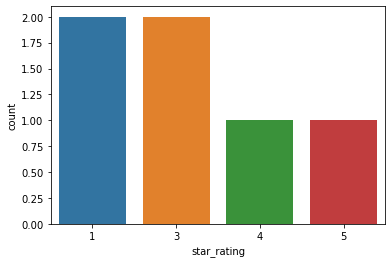

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

data1= rating_count[rating_count['product_title']=='007 Legends [Download]']
fig, ax = plt.subplots()
sns.barplot(data=data1, x='star_rating', y='count', ax=ax)

In [18]:
H.sort_values(by=['negative feedback'], ascending=False).head(14)

KeyError: 'negative_feedback'

In [ ]:
H.loc

In [ ]:
H_new = H.set_index('index')
H_new.head()

In [ ]:
H_new['star_rating'] = H_new['star_rating'].replace([1,2], 'negative')
H_new['star_rating'] = H_new['star_rating'].replace([4,5], 'positive')

In [ ]:
H_avg = H_new.groupby('star_rating').mean()
H_avg.head()

Negative top Topics: download 0.029, online 0.027, negative_feedback 0.021, worth_time 0.016 <br>
Positive top Topics: positive_feedback 0.020, difficulty 0.020, online 0.019, performance 0.018, 

## Topic Distribution Per Game

In [ ]:
H_new.loc[(H_new['product_title'] == 'Tropico 5') & (H_new['star_rating'] == 'positive')].mean().sort_values(ascending=False)

In [ ]:
H_new.loc[(H_new['product_title'] == 'Tropico 5') & (H_new['star_rating'] == 'negative')].mean().sort_values(ascending=False)